In [2]:
# Move up a directory (until the root of the git repo),
# but only if this has not been done before.
if 'in_correct_dir' not in locals():
    %cd -q ..
in_correct_dir = True
%pwd

'/home/wout/pp/code'

In [5]:
import io
import json
from pathlib import Path

import ipywidgets as W
from PIL import Image
from IPython.display import display

import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

In [25]:
# df = pd.read_csv("artifacts/results/mnist_default_k10_e5.csv")
# df = pd.read_csv("artifacts/results/mnist_default_k5_e10.csv")
# df = pd.read_csv("artifacts/results/cifar10_default_k5_e10.csv")
df = pd.read_csv("results.csv")
df.syst_prediction = df.syst_prediction.map(lambda s: np.array(json.loads(s)))
df.asss_prediction = df.asss_prediction.map(lambda s: np.array(json.loads(s)))
display(df.dtypes)
display(df.head(10))
display(df.describe())

inst_index           int64
inst_label           int64
syst_features        int64
syst_prediction     object
syst_pred_loss     float64
syst_pred_score    float64
asss_prediction     object
asss_pred_loss       int64
dtype: object

,inst_index,inst_label,syst_features,syst_prediction,syst_pred_loss,syst_pred_score,asss_prediction,asss_pred_loss
0,2210,4,0,"[[0.01739480346441269, 0.8678627014160156, 0.0...",2.596806,0.0,[0.27680912613868713],0
1,1748,5,1,"[[0.11231746524572372, 0.13772310316562653, 0....",1.550630,1.0,[0.9999885559082031],0
2,1286,2,2,"[[0.007606790401041508, 0.005442420020699501, ...",0.153555,1.0,[0.8264197707176208],0
3,824,3,3,"[[6.278192472564115e-07, 3.823007318715099e-06...",0.002490,1.0,[0.9992419481277466],0
4,362,0,4,"[[0.27700042724609375, 0.682551383972168, 0.01...",1.283736,0.0,[0.8032363057136536],1
5,2211,6,0,"[[0.10587310791015625, 0.2699069380760193, 0.0...",0.653617,1.0,[0.41727060079574585],0
6,1749,4,1,"[[0.006672017276287079, 0.11008750647306442, 0...",0.126178,1.0,[0.8576616644859314],0
7,1287,1,2,"[[6.744206621078774e-05, 0.6827194690704346, 2...",0.381671,1.0,[0.944599449634552],0
8,825,6,3,"[[0.004469193052500486, 0.012811170890927315, ...",0.419245,1.0,[0.5004576444625854],0
9,363,5,4,"[[6.047647730156314e-06, 0.0011563561856746674...",0.056652,1.0,[0.9993094205856323],0


,inst_index,inst_label,syst_features,syst_pred_loss,syst_pred_score,asss_pred_loss
count,500.000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,1335.500,3.066000,2.00000,0.616618,0.784000,0.264000
std,654.659,1.951733,1.41563,1.089387,0.411926,0.715071
min,362.000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,848.750,1.000000,1.00000,0.019487,1.000000,0.000000
50%,1335.500,3.000000,2.00000,0.187616,1.000000,0.000000
75%,1822.250,5.000000,3.00000,0.933992,1.000000,0.000000
max,2309.000,6.000000,4.00000,16.041075,1.000000,8.000000


In [26]:
from sklearn.metrics import classification_report
print(f"Num base mispredictions {(df.syst_pred_score == 0).sum() }")
print(classification_report(df.inst_label, df.syst_prediction.map(lambda p: np.argmax(p, axis=1)[0])))

Num base mispredictions 108
              precision    recall  f1-score   support

           0       0.77      0.93      0.85        59
           1       0.80      0.64      0.71        75
           2       0.66      0.62      0.64        79
           3       0.97      1.00      0.98        58
           4       0.89      0.74      0.81        86
           5       0.94      0.99      0.96        76
           6       0.52      0.64      0.57        67

    accuracy                           0.78       500
   macro avg       0.79      0.80      0.79       500
weighted avg       0.79      0.78      0.78       500



asss_prediction,False,True
syst_pred_score,,
0.0,34,74
1.0,50,342


'Brier Score: 0.248'

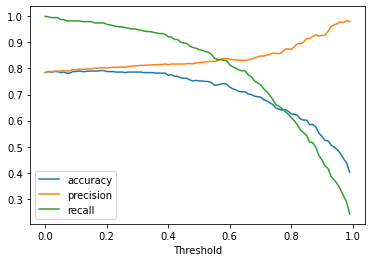

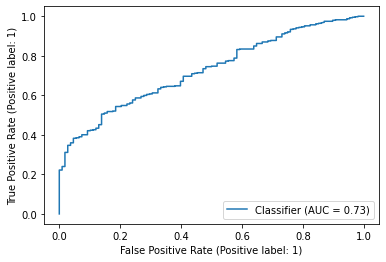

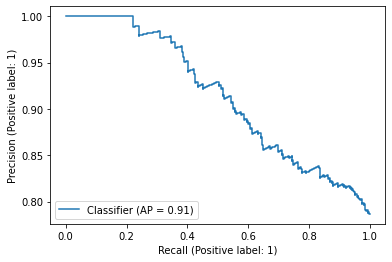

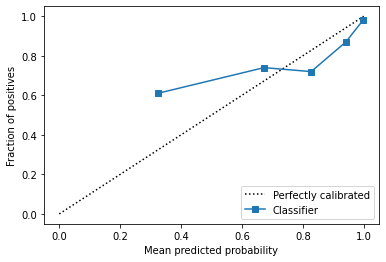

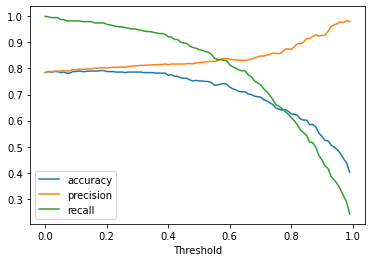

In [34]:
import sklearn.metrics as metrics
import sklearn.calibration as calibration


def metrics_for_threshold(df, threshold = 0.5):
    preds = df.asss_prediction.map(lambda p: p[0] > threshold)
    display(pd.crosstab(df.syst_pred_score, preds))
    display(f"Brier Score: {metrics.brier_score_loss(df.syst_pred_score, preds)}")

metrics_for_threshold(df, 0.5)
# metrics_for_treshold(df, 0.0)
# Make AUC
# Give it identity feature
metrics.RocCurveDisplay.from_predictions(y_true=df.syst_pred_score, y_pred=df.asss_prediction.map(lambda p: p[0]))
metrics.PrecisionRecallDisplay.from_predictions(y_true=df.syst_pred_score, y_pred=df.asss_prediction.map(lambda p: p[0]))
calibration.CalibrationDisplay.from_predictions(y_true=df.syst_pred_score, y_prob=df.asss_prediction.map(lambda p: p[0]), strategy="quantile")

def plot_thresholding(df):
    def metrics_for_threshold2(df, threshold):
        y_true = df.syst_pred_score
        y_pred = df.asss_prediction.map(lambda p: p[0] > threshold)
        return (
            metrics.accuracy_score(y_true, y_pred),
            metrics.precision_score(y_true, y_pred),
            metrics.recall_score(y_true, y_pred),
            metrics.balanced_accuracy_score(y_true, y_pred)
    )
    thresholds = np.arange(0, 1, 0.01)
    accuracies, precisions, recalls, bal_accs = zip(*[metrics_for_threshold2(df, t) for t in thresholds])
    fig = plt.figure()
    ax = plt.gca()
    # ax = fig.axes[0]
    ax.plot(thresholds, accuracies, label="accuracy")
    ax.plot(thresholds, precisions, label="precision")
    ax.plot(thresholds, recalls, label="recall")
    # ax.plot(thresholds, bal_accs, label="balanced accuracy")
    ax.set_xlabel("Threshold")
    ax.legend()
    return fig
    
    
plot_thresholding(df)